In [669]:
#%matplotlib inline
import sys
import os


import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as ndi
import pandas as pd
import networkx as nx
import scipy.stats as stt
#optional for nicer plots
import seaborn
clrs = seaborn.color_palette(n_colors=6)
seaborn.set(style='ticks',font_scale=1.5)

In [1083]:
poke_pos = np.array([1,-1])*np.array([ [149,0],
                                 [68,19],[231,19],
                               [0,62],[149,62],[298,62],
                                 [68,105],[231,105],
                                      [149,124]])

In [1280]:
sys.path.append("/Users/yves/Desktop/retreat_data_dir/code/")
from mecll.task import plot_activity_on_graph

In [1281]:
def load_data(selected_session,by_dir=False):
    
    """ Function to load data structured according to the format
        that the data were delivered to the retreat for
    """
    all_data_dir = '/Users/yves/Desktop/retreat_data_dir/data/'
    all_data_folders = sorted([i for i in os.listdir(all_data_dir) if 'ks25' in i])
    root_dir = os.path.join(all_data_dir,all_data_folders[selected_session])
    spkT = np.load(os.path.join(root_dir,'spkT_task.npy'))


    #This array is the same shape as spkT but shows which cluster each of the spikes in spkT belongs to
    spkC = np.load(os.path.join(root_dir,'spkC_task.npy'))

    #This is basically a big table (you can open it in excel) which contains
    #relevant information about each time the animal poked one of the ports
    task_event_df = pd.read_csv(os.path.join(root_dir,'task_event_table.csv'),index_col=0)

    #
    response_table = np.load(os.path.join(root_dir,'neuron_response_table.npy'))
    #alternatively to change the time window


    #not all cluster in spkC correspond to single units. Single units is an array of the clusters that are single units
    single_units = np.load(os.path.join(root_dir,'single_units.npy'))
    
    
    seq0 = np.array(eval(task_event_df.loc[task_event_df['task_nr']==0]['current_sequence'].values[0]))
    seq1 = np.array(eval(task_event_df.loc[task_event_df['task_nr']==1]['current_sequence'].values[0]))
    
    
    graph_type0 = task_event_df.loc[task_event_df['task_nr']==0]['graph_type'].values[0]
    graph_type1 = task_event_df.loc[task_event_df['task_nr']==0]['graph_type'].values[0]
    
    if by_dir:
        firing_rate_maps = get_task_responses_by_direction(task_event_df,response_table)
    else:
        firing_rate_maps = get_task_responses(task_event_df,response_table)
    
    return firing_rate_maps, task_event_df,seq0,seq1,graph_type0,graph_type1

In [1282]:
def get_task_responses_by_direction(task_event_df,response_table):
    """ 
    Use the columns of the task_event_df to filter neural activity. 
    In this example build separate firing rate maps for each of the
    tasks, selecting only trials where subjects poked the correct poke.
    
    
    """
    
    
    n_neurons = response_table.shape[1]
    n_ports = 9
    n_tasks = 2
    n_direction = 2
    
    #set variables to nan to not confuse missing data for no responses
    firing_rate_maps = np.zeros([n_neurons,n_ports,n_tasks,n_direction]) + np.nan
    
    #for each task
    for task in [0,1]:
        
        for port in range(n_ports):  #for each port
            
            for dix,direction in enumerate(np.unique(task_event_df['direction'].values)):

                #Select indices of pokes where...
                table_index = task_event_df.loc[(task_event_df['task_nr']==task) &  #task_nr was task
                                                (task_event_df['correct']==True) &  #the poke was to the correct port
                                                (task_event_df['port']==port) &       #the port poked was port
                                                (task_event_df['direction']==direction)
                                               ].index           
                #print(len(table_index))
                #get the average
                firing_rate_maps[:,int(port),int(task),dix] = np.nanmean(response_table[table_index],axis=0)
    return firing_rate_maps
                                         

In [1283]:
def get_task_responses(task_event_df,response_table):
    """ 
    Use the columns of the task_event_df to filter neural activity. 
    In this example build separate firing rate maps for each of the
    tasks, selecting only trials where subjects poked the correct poke.
    
    
    """
    
    
    n_neurons = response_table.shape[1]
    n_ports = 9
    n_tasks = 2
    n_direction = 2
    
    #set variables to nan to not confuse missing data for no responses
    firing_rate_maps = np.zeros([n_neurons,n_ports,n_tasks]) + np.nan
    
    #for each task
    for task in [0,1]:
        
        for port in range(n_ports):  #for each port
            
            #for dix,direction in enumerate(np.unique(task_event_df['direction'].values)):

                #Select indices of pokes where...
            table_index = task_event_df.loc[(task_event_df['task_nr']==task) &  #task_nr was task
                                            (task_event_df['correct']==True) &  #the poke was to the correct port
                                            (task_event_df['port']==port)        #the port poked was port
                                            #(task_event_df['direction']==direction)
                                           ].index           
            #print(len(table_index))
            #get the average
            firing_rate_maps[:,int(port),int(task)] = np.nanmean(response_table[table_index],axis=0)
    return firing_rate_maps

In [1284]:

firing_rate_maps,task_event_df,seq0,seq1,graph_type0,graph_type1, = load_data(4)
#spatial_map  = np.nanmean(firing_rate_maps,axis=(2,3))
mds_frm = firing_rate_maps.swapaxes(0,2) #- spatial_map[:,:,None,None]
#valid_ix = np.where(~np.isnan(np.sum(firing_rate_maps,axis=(0,2,3))))[0]
#frm = np.hstack([mds_frm[:,seq0,0,0],mds_frm[:,seq0,0,1],mds_frm[:,seq1,1,0],mds_frm[:,seq1,1,1]])

In [1285]:
mds_

NameError: name 'mds_' is not defined

In [1286]:
mds_frm.shape

(2, 9, 274)

In [1287]:
graph_type1

'line'

In [1288]:
#mean_state_resps = np.nanmean(mds_frm,axis=3).swapaxes(0,2)

In [1289]:
from scipy.spatial.distance import pdist
from scipy.spatial import distance_matrix

def zscore(dat): return (dat-np.mean(dat))/np.std(dat)

In [1290]:
seq0_2 = np.array([list(seq0).index(i) for i in range(9)])
seq1_2 = np.array([list(seq1).index(i) for i in range(9)])

In [1291]:
seq0

array([8, 1, 6, 3, 4, 0, 7, 2, 5])

In [1292]:
#seq1

In [1293]:
task_1_distance

array([[-0., -4., -2., -2., -1., -3., -3., -1., -5.],
       [-4., -0., -6., -2., -3., -7., -1., -5., -1.],
       [-2., -6., -0., -4., -3., -1., -5., -1., -7.],
       [-2., -2., -4., -0., -1., -5., -1., -3., -3.],
       [-1., -3., -3., -1., -0., -4., -2., -2., -4.],
       [-3., -7., -1., -5., -4., -0., -6., -2., -8.],
       [-3., -1., -5., -1., -2., -6., -0., -4., -2.],
       [-1., -5., -1., -3., -2., -2., -4., -0., -6.],
       [-5., -1., -7., -3., -4., -8., -2., -6., -0.]])

In [1294]:
1-8

-7

In [1295]:
9 +(8-2)

15

In [2089]:
def loop_distance_matrix(seq,p=2):
    seq = list(seq)
    d = np.zeros([9,9])
    for i in range(9):
        for j in range(9):
            ind1 = seq.index(i)
            ind2 = seq.index(j)
            d[i,j] = min([abs(ind1-ind2),abs(9+(ind1-ind2)),abs(9+(ind2-ind1))])**p
    return d

In [2090]:
def line_distance_matrix(seq,p=1):
    seq = list(seq)
    d = np.zeros([9,9])
    for i in range(9):
        for j in range(9):
            ind1 = seq.index(i)
            ind2 = seq.index(j)
            d[i,j] = abs(ind1-ind2)**p
    return d

In [2061]:
#task_1_distance = loop_distance_matrix(seq0,p=2)
#task_2_distance = loop_distance_matrix(seq1,p=2)

In [2062]:
if graph_type0=='loop': 
    task_1_distance = -loop_distance_matrix(seq0)
else: 
    task_1_distance =  -line_distance_matrix(seq0)#-(distance_matrix(seq0.reshape(-1,1),seq0.reshape(-1,1),p=1))
if graph_type1=='loop':
    task_2_distance = -loop_distance_matrix(seq1)
else:
    task_2_distance = -line_distance_matrix(seq1)#distance_matrix(seq1.reshape(-1,1),seq1.reshape(-1,1),p=1)
            
#task_1_distance = -(distance_matrix(seq0_2.reshape(-1,1),seq0_2.reshape(-1,1),p=1)%mod0)
#task_2_distance = -distance_matrix(seq1.reshape(-1,1)%mod1,seq1.reshape(-1,1)%mod1,p=2)
spatial_distance = -distance_matrix(poke_pos,poke_pos,p=1)

In [2063]:
#for 

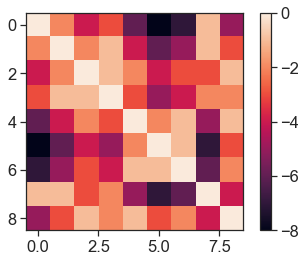

In [2064]:
plt.imshow(task_1_distance)
plt.colorbar()

In [2065]:
import statsmodels.api as sm

In [2066]:
task1_corrs = np.corrcoef(mean_state_resps[0])
task2_corrs = np.corrcoef(mean_state_resps[1])

In [2067]:
beta = np.linalg.inv(X.T@X)@X.T@y

In [2068]:
plt.imshow((X@beta).reshape(8,9))
plt.colorbar()

ValueError: cannot reshape array of size 240 into shape (8,9)

In [2069]:
np.corrcoef(y,(X@beta))

array([[1.        , 0.75430223],
       [0.75430223, 1.        ]])

In [2070]:
plt.imshow(y.reshape(8,9))
plt.colorbar()

ValueError: cannot reshape array of size 240 into shape (8,9)

In [2071]:
def remove_diagonal(A):
    removed = A[~np.eye(A.shape[0], dtype=bool)].reshape(A.shape[0], int(A.shape[0])-1, -1)
    return np.squeeze(removed)


In [2072]:
X = np.vstack([np.ones_like(remove_diagonal(spatial_distance).flatten()),
               zscore(remove_diagonal(spatial_distance).flatten()),
               zscore(remove_diagonal(task_1_distance).flatten()),
               zscore(remove_diagonal(task_2_distance).flatten())
              ]).T
y = remove_diagonal(task1_corrs).flatten()
res = sm.OLS(y,X,hasconst=True).fit()

In [2073]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.113
Model:                            OLS   Adj. R-squared:                  0.074
Method:                 Least Squares   F-statistic:                     2.879
Date:                Sun, 14 Nov 2021   Prob (F-statistic):             0.0423
Time:                        20:19:13   Log-Likelihood:                 76.509
No. Observations:                  72   AIC:                            -145.0
Df Residuals:                      68   BIC:                            -135.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0618      0.010      6.099      0.000       0.042       0.082
x1             0.0171      0.010      1.676      0.098      -0.003       0.037
x2            -0.0201      0.010     -1.968      0.053      -0.041       0.000
x3            -0.0147      0.010     -1.442      0.154      -0.035       0.006
==============================================================================
Omnibus:                        0.888   Durbin-Watson:                   1.563
Prob(Omnibus):                  0.641   Jarque-Bera (JB):                0.782
Skew:                          -0.250   Prob(JB):                        0.676
Kurtosis:                       2.896   Cond. No.                         1.15
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [2074]:

y = remove_diagonal(task2_corrs).flatten()
res2 = sm.OLS(y,X,hasconst=True).fit()

In [2075]:
res2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.113
Model:                            OLS   Adj. R-squared:                  0.074
Method:                 Least Squares   F-statistic:                     2.879
Date:                Sun, 14 Nov 2021   Prob (F-statistic):             0.0423
Time:                        20:19:14   Log-Likelihood:                 76.509
No. Observations:                  72   AIC:                            -145.0
Df Residuals:                      68   BIC:                            -135.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0618      0.010      6.099      0.000       0.042       0.082
x1             0.0171      0.010      1.676      0.098      -0.003       0.037
x2            -0.0201      0.010     -1.968      0.053      -0.041       0.000
x3            -0.0147      0.010     -1.442      0.154      -0.035       0.006
==============================================================================
Omnibus:                        0.888   Durbin-Watson:                   1.563
Prob(Omnibus):                  0.641   Jarque-Bera (JB):                0.782
Skew:                          -0.250   Prob(JB):                        0.676
Kurtosis:                       2.896   Cond. No.                         1.15
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [2076]:
res.params

array([ 0.06184391,  0.01710821, -0.02014127, -0.01472281])

In [2077]:
mean_state_resps

array([[[ 9.32210952e-02,  2.05208903e+00,  7.06775843e-01, ...,
         -1.11444166e+00,  2.69947787e+00, -1.09372806e+00],
        [ 1.43889292e+00,  9.29571291e-01, -3.12879647e-01, ...,
         -2.02840803e+00, -3.04620880e-01, -2.04509786e-01],
        [ 6.51073815e-01,  3.31347836e-01, -5.73403542e-02, ...,
          5.52530421e-01,  6.56730446e-01, -2.16904319e+00],
        ...,
        [ 1.14519795e+00,  2.15763959e-01,  4.49747822e-01, ...,
         -9.86547071e-01,  1.30411218e-16, -4.77189502e-01],
        [-3.97878442e-02,  3.46640813e-01,  2.75233700e-01, ...,
         -2.57847530e-01,  3.62002636e-01, -4.66344286e-01],
        [-3.94734114e-01,  9.29059976e-01,  3.22081990e-01, ...,
          6.31799223e-01,  7.48056339e-01, -1.38370451e+00]],

       [[-9.32210952e-02, -2.05208903e+00, -7.06775843e-01, ...,
          1.11444166e+00, -2.69947787e+00,  1.09372806e+00],
        [-1.43889292e+00, -9.29571291e-01,  3.12879647e-01, ...,
          2.02840803e+00,  3.04620880e

ValueError: color kwarg must have one color per data set. 2 data sets and 1 colors were provided

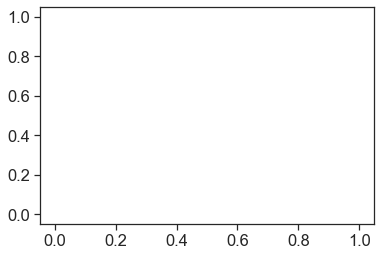

In [2078]:
seaborn.distplot(firing_rate_maps.max(axis=(1,2)),kde=0,bins=np.linspace(0,10,num=50))
plt.xlim(0,1)

In [2079]:
firing_rate_maps.shape

(394, 9, 2, 2)

In [2349]:
all_beta = []
all_pvals = []
for sess_ix in range(8):
    tmp  = []
    tmp_pvals = []
    firing_rate_maps,task_event_df,seq0,seq1,graph_type0,graph_type1, = load_data(sess_ix)
    mxs = firing_rate_maps.max(axis=(1,2))
    firing_rate_maps = firing_rate_maps - np.mean(firing_rate_maps,axis=2)[:,:,None]
    firing_rate_maps = firing_rate_maps[mxs>.5]
    mean_state_resps = firing_rate_maps.swapaxes(0,2)
    mean_state_resps = (mean_state_resps - np.mean(mean_state_resps,axis=(0,1))[None,None,:])/np.std(mean_state_resps,axis=(0,1))[None,None,:]
    mean_state_resps = np.nan_to_num(mean_state_resps)
    #mean_state_resps = np.nanmean(mds_frm,axis=3).swapaxes(0,2)
    if graph_type0=='loop': 
        task_1_distance = -loop_distance_matrix(seq0)
    else: 
        task_1_distance =  -line_distance_matrix(seq0)
    if graph_type1=='loop':
        task_2_distance = -loop_distance_matrix(seq1)
    else:
        task_2_distance = -line_distance_matrix(seq1)

    spatial_distance = -distance_matrix(poke_pos,poke_pos,p=1)
    
    msr0 = ((mean_state_resps[0] - np.mean(mean_state_resps[0],axis=0))/np.std(mean_state_resps[0],axis=0))
    msr1 = ((mean_state_resps[1] - np.mean(mean_state_resps[1],axis=0))/np.std(mean_state_resps[1],axis=0))
    task1_corrs = np.corrcoef(msr0)
    task2_corrs = np.corrcoef(msr1)
    
    
    #
    X = np.vstack([np.ones_like(remove_diagonal(spatial_distance).flatten()),
               zscore(remove_diagonal(spatial_distance).flatten()),
               zscore(remove_diagonal(task_1_distance).flatten()),
               zscore(remove_diagonal(task_2_distance).flatten())
              ]).T
    y = remove_diagonal(task1_corrs).flatten()
    beta = np.linalg.inv(X.T@X)@X.T@y
    res = sm.OLS(y,X,hasconst=True).fit()
    
    
    tmp.append(beta.copy())
    tmp_pvals.append(res.pvalues)
    
    y = remove_diagonal(task2_corrs).flatten()
    beta = np.linalg.inv(X.T@X)@X.T@y
    res = sm.OLS(y,X,hasconst=True).fit()
    
    tmp_pvals.append(res.pvalues)
    tmp.append(beta.copy())
    
    all_beta.append(tmp)
    all_pvals.append(tmp_pvals)
    #assert np.allclose(beta,res.params)

In [2361]:
np.mean(msr0[:,0])

1.7270135938613546e-16

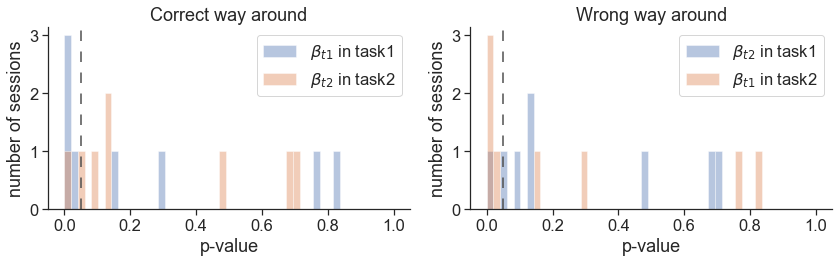

In [2350]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.title("Correct way around")
seaborn.distplot(np.array(all_pvals)[:,0,-2],kde=0,bins=np.linspace(0,1,num=50),label=r'$\beta_{t1}$ in task1')
seaborn.distplot(np.array(all_pvals)[:,1,-1],kde=0,bins=np.linspace(0,1,num=50),label=r'$\beta_{t2}$ in task2')
plt.axvline(x=0.05,dashes=(7,7),color='.3')
plt.xlabel("p-value")
plt.ylabel("number of sessions")
plt.legend(loc=1)
seaborn.despine()

plt.subplot(1,2,2)
plt.title("Wrong way around")
seaborn.distplot(np.array(all_pvals)[:,0,-1],kde=0,bins=np.linspace(0,1,num=50),label=r'$\beta_{t2}$ in task1')
seaborn.distplot(np.array(all_pvals)[:,1,-2],kde=0,bins=np.linspace(0,1,num=50),label=r'$\beta_{t1}$ in task2')
plt.axvline(x=0.05,dashes=(7,7),color='.3')
plt.xlabel("p-value")
plt.ylabel("number of sessions")
plt.legend(loc=1)
seaborn.despine()
plt.tight_layout()

In [2351]:
np.array(all_pvals)[:,:,-2:].shape

(8, 2, 2)

In [2352]:
res.pvalues

array([1.49772745e-17, 4.00861318e-05, 7.61518461e-01, 4.81748078e-01])

In [2353]:
#n_sessions x n_tasks x n_params
all_beta = np.array(all_beta)

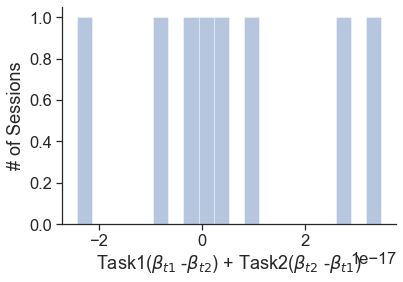

In [2354]:
#n_sessions x n_tasks x n_params
all_beta = np.array(all_beta)

t1_m_t2_inT1 = (all_beta[:,0,-2] - all_beta[:,0,-1])
t1_m_t2_inT2 = (all_beta[:,1,-1] - all_beta[:,1,-2])

seaborn.distplot(t1_m_t2_inT1 + t1_m_t2_inT2,kde=0,bins=20)
plt.xlabel(r"Task1($\beta_{t1}$ -$\beta_{t2}$) + Task2($\beta_{t2}$ -$\beta_{t1}$)")
plt.ylabel("# of Sessions")
seaborn.despine()

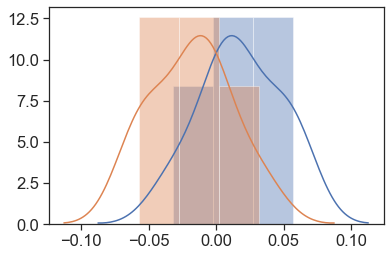

In [2355]:
seaborn.distplot(t1_m_t2_inT1)
seaborn.distplot(t1_m_t2_inT2)

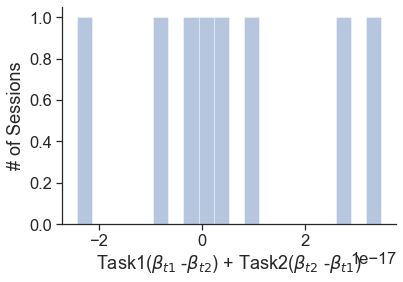

In [2356]:
seaborn.distplot(t1_m_t2_inT1 + t1_m_t2_inT2,kde=0,bins=20)
plt.xlabel(r"Task1($\beta_{t1}$ -$\beta_{t2}$) + Task2($\beta_{t2}$ -$\beta_{t1}$)")
plt.ylabel("# of Sessions")
seaborn.despine()

In [2357]:
stt.ttest_1samp(t1_m_t2_inT1 + t1_m_t2_inT2,popmean=0)

Ttest_1sampResult(statistic=0.7445967465797968, pvalue=0.4807604377694731)

# RSA Task distance with direction

In [ ]:
sp

In [1374]:

#firing_rate_maps,task_event_df,seq0,seq1,graph_type0,graph_type1, = load_data(0,by_dir=True)
spatial_map  = np.nanmean(firing_rate_maps,axis=(2,3))
mds_frm = firing_rate_maps - spatial_map[:,:,None,None]
#valid_ix = np.where(~np.isnan(np.sum(firing_rate_maps,axis=(0,2,3))))[0]
#firing_rate_maps[:,int(port),int(task),dix]
frm = np.hstack([mds_frm[:,seq0,0,0],mds_frm[:,seq0,0,1],mds_frm[:,seq1,1,0],mds_frm[:,seq1,1,1]])

In [1375]:
frm = np.hstack([mds_frm[:,seq0,0,0],mds_frm[:,seq0,0,1],mds_frm[:,seq1,1,0],mds_frm[:,seq1,1,1]])
frm_t1 = frm[:,:18]
frm_t2 = frm[:,18:]

In [1376]:
#this constructs the appropriate things if everything is ordered correctly according to states

T = np.zeros([18,18])
for i in range(9):
    T[i,(i+1)%9] = .95
    T[i,9+(i-1)%9] =0.05
    
for i in range(9,18):
    T[i,(i+1)%9] = .05
    T[i,9+(i-1)%9] =0.95

In [1845]:
# def get_C_line_task(seq0,p=0.95):
#     """ Finish this requires updating the edges of the line"""
#     T1 = np.zeros([18,18])
#     for i in range(9):
#         T1[seq0[i],seq0[(i+1)%9]] = p
#         T1[seq0[i],9+seq0[(i-1)%9]] = 1-p

#     for i in range(9,18):
#         T1[seq0[i%9]+9,seq0[(i+1)%9]] = 1-p
#         T1[seq0[i%9]+9,9+seq0[(i-1)%9]] = p

        
# # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
#     T1[0] = 0; T1[0,1] = 1  #going to the right in state 0 will go to 1
#     T1[8] = 0; T1[8,-1] = 1   #going to the right in state 9 will go to state 8
#     T1[9] = 0; T1[9,1] = 1    #going to the left in state 0 will go to state 1
#     T1[-1] = 0; T1[-1,-1] = 1       #going to the left in state 
    
#     task_1_distance = -np.log(expm(T1))
#     return T1, task_1_distance

In [2279]:
def get_C_loop_task(seq0,p=0.95):
    """p is the probability of continueing in the same direction"""
    #this constructs the appropriate things if everything is ordered correctly according to states

    T1 = np.zeros([18,18])
    for i in range(9):
        T1[seq0[i],seq0[(i+1)%9]] = p
        T1[seq0[i],9+seq0[(i-1)%9]] = 1-p

    for i in range(9,18):
        T1[seq0[i%9]+9,seq0[(i+1)%9]] = 1-p
        T1[seq0[i%9]+9,9+seq0[(i-1)%9]] = p

    task_1_distance = -np.log(expm(T1))
    #task_1_distance = np.linalg.pinv(np.eye(len(T1)) - 0.1  * T1)
    return T1, task_1_distance

In [2280]:
def get_C_line_task(seq0,p=0.95):
    """ Finish this requires updating the edges of the line"""
    T1 = np.zeros([18,18])
    for i in range(9):
        T1[seq0[i],seq0[(i+1)%9]] = p
        T1[seq0[i],9+seq0[(i-1)%9]] = 1-p

    for i in range(9,18):
        T1[seq0[i%9]+9,seq0[(i+1)%9]] = 1-p
        T1[seq0[i%9]+9,9+seq0[(i-1)%9]] = p

        

    T1[seq0[0]] = 0; T1[seq0[0],seq0[1]] = 1  #going to the right in state 0 will go to 1
    T1[seq0[8]] = 0; T1[seq0[8],seq0[-1]+9] = 1   #going to the right in state 9 will go to state 8
    T1[seq0[9%9]+9] = 0; T1[seq0[9%9]+9,seq0[0]] = 1    #going to the left in state 0 will go to state 1
    T1[seq0[-1]+9] = 0; T1[seq0[-1]+9,seq0[-2]+9] = 1       #going to the left in state 
    
    task_1_distance = -np.log(expm(T1))
    #evals,evecs = np.linalg.eig(T1)
    #mx = np.max(np.abs(evals))
    #task_1_distance = (evecs@(evals_mtx**50)@np.linalg.inv(evecs)).real
    #task_1_distance = np.linalg.pinv(np.eye(len(T1)) - 0.1  * T1)
    return T1, task_1_distance

In [2281]:
seq0

array([0, 2, 4, 3, 6, 8, 7, 1, 5])

In [2282]:
T1[0]

array([0.  , 0.  , 0.95, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.05, 0.  , 0.  , 0.  ])

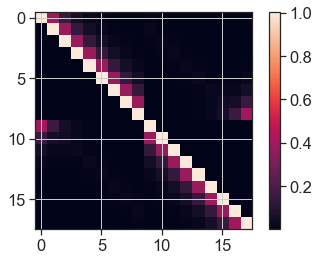

In [2314]:
T1,C1 = get_C_line_task(np.arange(9))
plt.imshow(np.linalg.inv(np.eye(len(T1))- .4*T1))
plt.grid()
plt.colorbar()

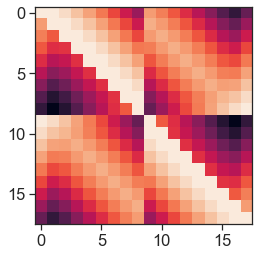

In [2316]:
plt.imshow(-C1)

In [2285]:
T1[0]

array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.])

In [2286]:
T1,C1 = get_C_line_task(seq0)

In [2287]:
evals,evecs = np.linalg.eig(T1)
oo = (evecs@(evals_mtx**50)@np.linalg.inv(evecs)).real

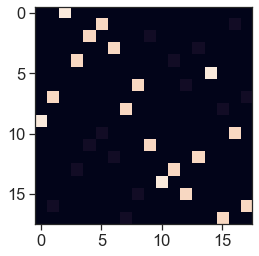

In [2288]:
plt.imshow(T1)

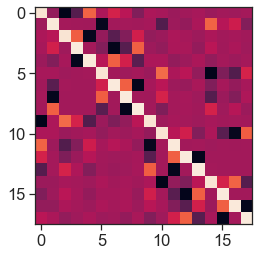

In [2289]:
plt.imshow(np.linalg.pinv(np.eye(len(T1)) - -.7  * T1))

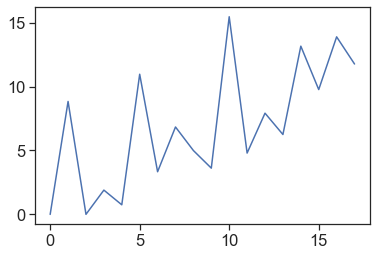

In [2290]:
plt.plot(C1[0])

In [2291]:
ix = 9
print(T1[ix][:9])
print(T1[ix][9:])

[1. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [2292]:
#this constructs the appropriate things if everything is ordered correctly according to states

T1 = np.zeros([18,18])
for i in range(9):
    T1[seq0[i],seq0[(i+1)%9]] = .95
    T1[seq0[i],9+seq0[(i-1)%9]] =0.05
    
for i in range(9,18):
    T1[seq0[i%9]+9,seq0[(i+1)%9]] = .05
    T1[seq0[i%9]+9,9+seq0[(i-1)%9]] =0.95

In [2293]:
#this constructs the appropriate things if everything is ordered correctly according to states

T2 = np.zeros([18,18])
for i in range(9):
    T2[seq1[i],seq1[(i+1)%9]] = .95
    T2[seq1[i],9+seq1[(i-1)%9]] =0.05
    
for i in range(9,18):
    T2[seq1[i%9]+9,seq1[(i+1)%9]] = .05
    T2[seq1[i%9]+9,9+seq1[(i-1)%9]] =0.95

In [2294]:
task_1_distance = -np.log(expm(T1))
task_2_distance = -np.log(expm(T2))

In [2295]:
evals, evecs = np.linalg.eig(T.T)
evals_mtx = np.eye(len(evals))*evals
evec1 = evecs[:,np.isclose(evals, 1)]

#Since np.isclose will return an array, we've indexed with an array
#so we still have our 2nd axis.  Get rid of it, since it's only size 1.
evec1 = evec1[:,0]

stationary = evec1 / evec1.sum()

#eigs finds complex eigenvalues and eigenvectors, so you'll want the real part.
stationary = stationary.real


AttributeError: 'tuple' object has no attribute 'T'

In [2296]:
from scipy.linalg import expm

In [2297]:
C2 = -np.log(evecs@expm(evals_mtx)@np.linalg.inv(evecs))

In [2298]:
spatial_distance =  spatial_distance = -distance_matrix(np.vstack([poke_pos,poke_pos]),
                                                        np.vstack([poke_pos,poke_pos]),p=1)

In [2299]:
task1_corrs = np.corrcoef(frm_t1.T)
task2_corrs = np.corrcoef(frm_t2.T) 

select_indices = (np.eye(len(task1_corrs)) + np.isnan(task1_corrs) + np.isnan(task2_corrs))==0

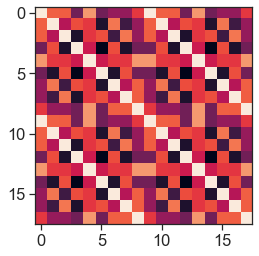

In [2300]:
plt.imshow(spatial_distance)

In [2301]:
y = zscore(task2_corrs[select_indices].flatten())
X = np.vstack([np.ones_like(y),
           zscore(spatial_distance[select_indices].flatten()),
           zscore(task_1_distance[select_indices].flatten()),
           zscore(task_2_distance[select_indices].flatten())
          ]).T
beta = np.linalg.inv(X.T@X)@X.T@y
res = sm.OLS(y,X,hasconst=True).fit()


/Users/yves/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


IndexError: boolean index did not match indexed array along dimension 0; dimension is 18 but corresponding boolean dimension is 5

In [2302]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.102
Model:                            OLS   Adj. R-squared:                  0.090
Method:                 Least Squares   F-statistic:                     8.913
Date:                Sun, 14 Nov 2021   Prob (F-statistic):           1.28e-05
Time:                        21:18:09   Log-Likelihood:                 125.75
No. Observations:                 240   AIC:                            -243.5
Df Residuals:                     236   BIC:                            -229.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8358      0.009     89.614      0.000       0.817       0.854
x1             0.0483      0.009      5.155      0.000       0.030       0.067
x2            -0.0029      0.009     -0.314      0.754      -0.021       0.016
x3            -0.0017      0.009     -0.185      0.854      -0.020       0.017
==============================================================================
Omnibus:                       45.768   Durbin-Watson:                   1.670
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               65.695
Skew:                          -1.203   Prob(JB):                     5.43e-15
Kurtosis:                       3.882   Cond. No.                         1.16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# batch over all tasks

In [2376]:
all_beta = []
all_pvals = []
for sess_ix in range(8):
    tmp  = []
    tmp_pvals = []
    firing_rate_maps,task_event_df,seq0,seq1,graph_type0,graph_type1, = load_data(sess_ix,by_dir=True)
    mxs = np.nanmax(firing_rate_maps,axis=(1,2,3))
    firing_rate_maps = firing_rate_maps[mxs>5]
    #spatial_map  = np.nanmean(firing_rate_maps,axis=(2,3))
    mds_frm = firing_rate_maps #- spatial_map[:,:,None,None]

   
    
    frm = np.hstack([mds_frm[:,:,0,0],mds_frm[:,:,0,1],mds_frm[:,:,1,0],mds_frm[:,:,1,1]])
    frm_t1 = frm[:,:18].T
    frm_t2 = frm[:,18:].T

    if graph_type0=='loop': 
        task_1_distance = get_C_loop_task(seq0)[1]
    else: 
        task_1_distance =  get_C_line_task(seq0)[1]
    if graph_type1=='loop':
        task_2_distance = get_C_loop_task(seq1)[1]
    else:
        task_2_distance = get_C_line_task(seq1)[1]

    task_1_distance = np.nan_to_num(task_1_distance,np.nanmean(task_1_distance))
    task_2_distance = np.nan_to_num(task_2_distance,np.nanmean(task_2_distance))
    #spatial_distance = -distance_matrix(poke_pos,poke_pos,p=1)
    spatial_distance =   -distance_matrix(np.vstack([poke_pos,poke_pos]),
                                          np.vstack([poke_pos,poke_pos]),p=1)
    
    task1_corrs = np.corrcoef(frm_t1)
    task2_corrs = np.corrcoef(frm_t2)
    select_indices = (np.eye(len(task1_corrs)) + 
                      np.isnan(task1_corrs) + 
                      np.isnan(task2_corrs) + 
                      np.isnan(task_1_distance) + 
                      np.isnan(task_2_distance) + 
                      np.isnan(spatial_distance)
                     )==0
    
    #
    y = task1_corrs[select_indices].flatten()
    X = np.vstack([np.ones_like(y),
               zscore(spatial_distance[select_indices].flatten()),
               zscore(task_1_distance[select_indices].flatten()),
               zscore(task_2_distance[select_indices].flatten())
              ]).T
    
    #y = remove_diagonal(task1_corrs).flatten()
    #beta = np.linalg.pinv(X.T@X)@X.T@y
    res = sm.OLS(y,X,hasconst=True).fit()
    
    
    tmp.append(res.params)
    tmp_pvals.append(res.pvalues)
    
    y = task2_corrs[select_indices].flatten()
    #beta = np.linalg.pinv(X.T@X)@X.T@y
    res = sm.OLS(y,X,hasconst=True).fit()
    
    tmp_pvals.append(res.pvalues)
    tmp.append(res.params)
    
    all_beta.append(tmp)
    all_pvals.append(tmp_pvals)
    #assert np.allclose(beta,res.params)

/Users/yves/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher

No handles with labels found to put in legend.


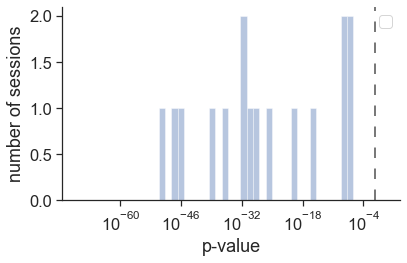

In [2377]:
seaborn.distplot(np.array(all_pvals)[:,:,1].flatten(),kde=0,bins=np.logspace(-70,1,num=50),)
plt.axvline(x=0.05,dashes=(7,7),color='.3')
#plt.xticks([1])
#plt.xlim(0,1)
plt.xscale('log')
plt.xlabel("p-value")
plt.ylabel("number of sessions")
plt.legend(loc=1)
seaborn.despine()
plt.tight_layout()

In [2378]:
np.array(all_pvals)[:,:,2]

array([[0.59940686, 0.80197233],
       [0.06274084, 0.73383098],
       [0.01556136, 0.97484913],
       [0.00439714, 0.00595021],
       [0.6112544 , 0.77027963],
       [0.66940644, 0.48330991],
       [0.38250453, 0.38908654],
       [0.64233191, 0.60688962]])

In [2379]:
np.logspace(-2,0,num=50)

array([0.01      , 0.01098541, 0.01206793, 0.01325711, 0.01456348,
       0.01599859, 0.01757511, 0.01930698, 0.02120951, 0.02329952,
       0.02559548, 0.02811769, 0.03088844, 0.03393222, 0.03727594,
       0.04094915, 0.04498433, 0.04941713, 0.05428675, 0.05963623,
       0.06551286, 0.07196857, 0.07906043, 0.08685114, 0.09540955,
       0.10481131, 0.11513954, 0.12648552, 0.13894955, 0.1526418 ,
       0.16768329, 0.184207  , 0.20235896, 0.22229965, 0.24420531,
       0.26826958, 0.29470517, 0.32374575, 0.35564803, 0.39069399,
       0.42919343, 0.47148664, 0.51794747, 0.5689866 , 0.62505519,
       0.68664885, 0.75431201, 0.82864277, 0.91029818, 1.        ])

In [2380]:
#plt.imshow(select_indices)

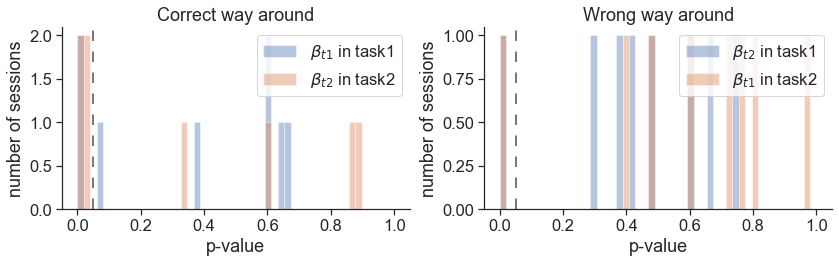

In [2381]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.title("Correct way around")
seaborn.distplot(np.array(all_pvals)[:,0,-2],kde=0,bins=np.linspace(0,1,num=50),label=r'$\beta_{t1}$ in task1')
seaborn.distplot(np.array(all_pvals)[:,1,-1],kde=0,bins=np.linspace(0,1,num=50),label=r'$\beta_{t2}$ in task2')
plt.axvline(x=0.05,dashes=(7,7),color='.3')
plt.xlabel("p-value")
plt.ylabel("number of sessions")
plt.legend(loc=1)
seaborn.despine()

plt.subplot(1,2,2)
plt.title("Wrong way around")
seaborn.distplot(np.array(all_pvals)[:,0,-1],kde=0,bins=np.linspace(0,1,num=50),label=r'$\beta_{t2}$ in task1')
seaborn.distplot(np.array(all_pvals)[:,1,-2],kde=0,bins=np.linspace(0,1,num=50),label=r'$\beta_{t1}$ in task2')
plt.axvline(x=0.05,dashes=(7,7),color='.3')
plt.xlabel("p-value")
plt.ylabel("number of sessions")
plt.legend(loc=1)
seaborn.despine()
plt.tight_layout()

In [2382]:
np.array(all_beta).shape

(8, 2, 4)

In [2383]:
t1_m_t2_inT1

array([ 0.00771686, -0.032119  ,  0.05740197,  0.05647009,  0.01398327,
        0.03494894, -0.00462993,  0.01152955])

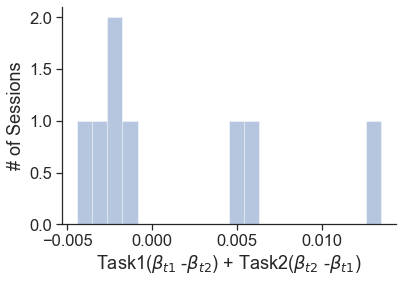

In [2384]:
#n_sessions x n_tasks x n_params
all_beta = np.array(all_beta)

t1_m_t2_inT1 = (all_beta[:,0,-2] - all_beta[:,0,-1])
t1_m_t2_inT2 = (all_beta[:,1,-1] - all_beta[:,1,-2])

seaborn.distplot(t1_m_t2_inT1 + t1_m_t2_inT2,kde=0,bins=20)
plt.xlabel(r"Task1($\beta_{t1}$ -$\beta_{t2}$) + Task2($\beta_{t2}$ -$\beta_{t1}$)")
plt.ylabel("# of Sessions")
seaborn.despine()

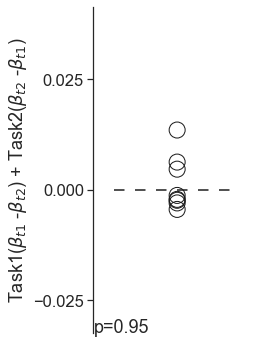

In [2386]:
plt.figure(figsize=(3,6))
plt.scatter([0]*8,t1_m_t2_inT1 + t1_m_t2_inT2,s=256,facecolor='',edgecolor='k')
plt.annotate('p=0.95',(.0,0),xycoords='axes fraction')
plt.xticks([])
plt.plot([-.15,.15],[0,0],color='k',linestyle='--',dashes=(7,7))
plt.ylabel(r"Task1($\beta_{t1}$ -$\beta_{t2}$) + Task2($\beta_{t2}$ -$\beta_{t1}$)")
plt.xlim(-.2,.2)
plt.locator_params('y',nbins=3)
seaborn.despine(bottom=True)

In [2362]:
stt.ttest_1samp(t1_m_t2_inT1 + t1_m_t2_inT2,0)

Ttest_1sampResult(statistic=0.7445967465797968, pvalue=0.4807604377694731)

# Check this works by ordering according to sequence

In [1972]:
all_beta = []
all_pvals = []
for sess_ix in range(8):
    tmp  = []
    tmp_pvals = []
    firing_rate_maps,task_event_df,seq0,seq1,graph_type0,graph_type1, = load_data(sess_ix,by_dir=True)
    mxs = np.nanmax(firing_rate_maps,axis=(1,2,3))
    firing_rate_maps = firing_rate_maps[mxs>.1]
    #spatial_map  = np.nanmean(firing_rate_maps,axis=(2,3))
    mds_frm = firing_rate_maps #- spatial_map[:,:,None,None]

   
    
    frm = np.hstack([mds_frm[:,seq0,0,0],mds_frm[:,seq0,0,1],mds_frm[:,seq0,1,0],mds_frm[:,seq0,1,1]])
    frm_t1 = frm[:,:18].T
    frm_t2 = frm[:,18:].T
    #mean_state_resps = firing_rate_maps.swapaxes(0,2)
    #mean_state_resps = (mean_state_resps - np.mean(mean_state_resps,axis=(0,1))[None,None,:])/np.std(mean_state_resps,axis=(0,1))[None,None,:]
    #mean_state_resps = np.nan_to_num(mean_state_resps)
    #mean_state_resps = np.nanmean(mds_frm,axis=3).swapaxes(0,2)
    if graph_type0=='loop': 
        task_1_distance = get_C_loop_task(np.arange(9))[1]
    else: 
        task_1_distance =  get_C_line_task(np.arange(9))[1]
    if graph_type1=='loop':
        task_2_distance = get_C_loop_task(np.arange(9))[1]
    else:
        task_2_distance = get_C_line_task(np.arange(9))[1]

    task_1_distance = np.nan_to_num(task_1_distance,np.nanmean(task_1_distance))
    task_2_distance = np.nan_to_num(task_2_distance,np.nanmean(task_2_distance))
    #spatial_distance = -distance_matrix(poke_pos,poke_pos,p=1)
    spatial_distance =   -distance_matrix(np.vstack([poke_pos[seq0],poke_pos[seq0]]),
                                          np.vstack([poke_pos[seq0],poke_pos[seq0]]),p=1)
    
    task1_corrs = np.corrcoef(frm_t1)
    task2_corrs = np.corrcoef(frm_t2)
    select_indices = (np.eye(len(task1_corrs)) + 
                      np.isnan(task1_corrs) + 
                      np.isnan(task2_corrs) + 
                      np.isnan(task_1_distance) + 
                      np.isnan(task_2_distance) + 
                      np.isnan(spatial_distance)
                     )==0
    
    #
    y = task1_corrs[select_indices].flatten()
    X = np.vstack([np.ones_like(y),
               zscore(spatial_distance[select_indices].flatten()),
               zscore(task_1_distance[select_indices].flatten()),
               zscore(task_2_distance[select_indices].flatten())
              ]).T
    
    #y = remove_diagonal(task1_corrs).flatten()
    #beta = np.linalg.pinv(X.T@X)@X.T@y
    res = sm.OLS(y,X,hasconst=True).fit()
    
    
    tmp.append(res.params)
    tmp_pvals.append(res.pvalues)
    
    y = task2_corrs[select_indices].flatten()
    #beta = np.linalg.pinv(X.T@X)@X.T@y
    res = sm.OLS(y,X,hasconst=True).fit()
    
    tmp_pvals.append(res.pvalues)
    tmp.append(res.params)
    
    all_beta.append(tmp)
    all_pvals.append(tmp_pvals)
    #assert np.allclose(beta,res.params)

/Users/yves/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher

In [2057]:
#np.array(all_pvals)[:,:,3]

In [2058]:
#np.array(all_pvals)[:,:,1]

In [1965]:

distance_matrix.shape

AttributeError: 'function' object has no attribute 'shape'